# Main Purpose: Find best ML/DL model and perform score analysis

## Summary of Procedures:
1. Identify input from working data by selecting the maximum claims for each patient in the year.
2. Vectorizing input (NLP) to feed into the machine learning model
3. Model training and Evaluation (Logistic Regression, MultinomialNB, Decision Trees, Xgboost, Neural networks)
4. Selecting Optimal model (Neural Network) and scoring performance

## Overview of Results:
A deep learning approach was identified as the optimal model. The model was trained using 300 epochs with early stopping where if the validation loss does not improve over the next 10 epochs, the model stops training. The epoch with the smallest validation loss was used. Additionally, the model architecture was tuned and the highest accuracy architecture was selected and implemented. The accuracy on the test set was 61.9 % with a precision of 0.62, a recall of 0.62 and ROC curve area of 0.66.

## Possible Improvements
- Tune the deep learning model even further (Especially learning rate, batch size).
- Demographic information was not considered due to vectorization of these data may confuse the model when adding for input. Thus, implementing demographic information (sex and ethnicity) after the attention layer should be performed.
- Sample size was reduced to improve efficiency to patients with at least one year of data. Using the entire 65k sample size as an input could be processed. 

In [48]:
#importing libraries
import numpy as np
import os
import pandas as pd
import ast
from datetime import datetime
import matplotlib.pyplot as plot
from numpy import array

import nltk
import os
import re
import bz2
import itertools
import codecs

import tensorflow as tf
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM,Dropout,Flatten,Conv1D,MaxPooling1D,Activation,BatchNormalization
from tensorflow.keras.layers import Flatten
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint,ReduceLROnPlateau
import matplotlib.pyplot as plt
import numpy as np
from nltk.tokenize import word_tokenize

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from itertools import chain
from sklearn import tree
from sklearn.feature_extraction.text import CountVectorizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Flatten, Conv1D, MaxPooling1D, Activation,Bidirectional
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import export_text
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix, auc,classification_report, roc_curve,roc_auc_score,precision_recall_curve,brier_score_loss
from matplotlib.pyplot import cm
from sklearn.calibration import calibration_curve

cwd=os.getcwd()
cwd

'C:\\Users\\david.ma\\Prediction Model'

## Selection of input data for each patient from dataset

In [2]:
#reading working data file
file = pd.read_csv('finallabeleddata.csv',dtype = {'Code':np.str_})

In [3]:
#evaluating an expression node
file['service_date']= file['service_date'].apply(ast.literal_eval)
file['codes']= file['codes'].apply(ast.literal_eval)
file['InputData']= file['InputData'].apply(ast.literal_eval)

In [4]:
#day computation function 
def date_converter(previous,after):
    """Retrieves two dates in form yyyy-mm-dd and computes the day difference between them

    Input
    --
    previous: first date
    after: second date
    
    Output
    --
    days: day difference between input
    
    """
    
    first=datetime(int(previous[0:4]),int(previous[5:7]),int(previous[8:10]))
    second=datetime(int(after[0:4]),int(after[5:7]),int(after[8:10]))
    
    return (second-first).days

In [5]:
#finding how long the patients are in the hospital
file['Input']='CC'
file['Discharge-hosptialized']='DD'
for i in file.index:
    file['Input'][i]=list(file['InputData'][i].values())
    file['Discharge-hosptialized'][i]=date_converter(list(file['InputData'][i].keys())[0],list(file['InputData'][i].keys())[-1])

<ipython-input-5-1c9744029f9a>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  file['Input'][i]=list(file['InputData'][i].values())
<ipython-input-5-1c9744029f9a>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  file['Discharge-hosptialized'][i]=date_converter(list(file['InputData'][i].keys())[0],list(file['InputData'][i].keys())[-1])


In [6]:
#filtering to patients who have at least stayed in the hospital for 1+ years
file['Discharge-hosptialized']=abs(file['Discharge-hosptialized'])
work=file[file['Discharge-hosptialized']>365]

In [8]:
#Appending patient data until 1 year for usage
work['workingData']='kk'

for i in work.index:
    lists=list(work['InputData'][i])
    free=[]
    for j in range(1,len(lists)):
        if date_converter(lists[0],lists[j])<=365:
            free.append(lists[j])
        else:
            work['workingData'][i]=free
            break             

<ipython-input-8-4698a3055b87>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  work['workingData']='kk'
<ipython-input-8-4698a3055b87>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  work['workingData'][i]=free
C:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:3437: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exec(code_obj, self.user_global_ns, self.user_ns)


In [9]:
#defining amount of days for every year
work['MaxYear']='oo'
work['MaxYearLength']='ll'
k=np.linspace(365,365,5)
z=np.linspace(1,5,5)
p=k*z

#Finding the maximum year visits/events specfic to each patient
for i in work.index:
    date_list=list(work['InputData'][i])
    f1=[]
    f2=[]
    f3=[]
    f4=[]
    f5=[]
    total=[]
    for j in range(len(date_list)):
        if date_converter(date_list[0],date_list[j])<=int(p[0]) and date_list[j]<date_list[-1]:
            f1.append(date_list[j])
            
        elif int(p[0])<date_converter(date_list[0],date_list[j])<=int(p[1]) and date_list[j]<=date_list[-1]:
            f2.append(date_list[j])
            
        elif int(p[1])<date_converter(date_list[0],date_list[j])<=int(p[2]) and date_list[j]<=date_list[-1]:
            f3.append(date_list[j])
            
        elif int(p[2])<date_converter(date_list[0],date_list[j])<=int(p[3]) and date_list[j]<=date_list[-1]:
            f4.append(date_list[j])
            
        elif int(p[3])<date_converter(date_list[0],date_list[j])<=int(p[4]) and date_list[j]<=date_list[-1]:
            f5.append(date_list[j])
            
    total=[f1,f2, f3, f4, f5]
    total=[x for x in total if x]
    
    max_finder=[]
    for h in total:
        max_finder.append(len(h))
        
    maxi=max(max_finder)    
    index=max_finder.index(maxi)    
    maximum=[total[k] for k in range(len(total)) if k==index][0]
    
    final=[]
    w=work['InputData'][i]
    
    for u in range(0,len(maximum)):
        kk=w.get(maximum[u])
        final.append(kk)
        
    work['MaxYear'][i]=final
    work['MaxYearLength'][i]=len(final)
              

<ipython-input-9-bb052c0dd432>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  work['MaxYear']='oo'
<ipython-input-9-bb052c0dd432>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  work['MaxYearLength']='ll'
<ipython-input-9-bb052c0dd432>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  work['MaxYear'][i]=final
<ipython-in

## Vectorizing Input 

In [11]:
#flattening all codes and joining it as a sentence (each code will be considered as one word)
label=work['Y']
xx=work['MaxYear'].apply(lambda x: list(chain(*[s.split('|') for s in x])))
zz=xx.apply(lambda x: " ".join(x))

In [12]:
#appending all codes into an array
empty=[]

for i in zz:
    empty.append(i)

#tokenizing each code  
all_words = []
for j in empty:
    tokenize_word = word_tokenize(j)
    for word in tokenize_word:
        all_words.append(word)

In [16]:
#vectorizing each code and generating a matrix
unique_words = set(all_words)
vocab_length=len(unique_words)+2
embedded_sentences = [one_hot(j, vocab_length) for j in empty]

In [18]:
#padding the matrix to make it a square to be feeded into the model
word_count = lambda sentence: len(word_tokenize(sentence))
longest_sentence = max(empty, key=word_count)
length_long_sentence = len(word_tokenize(longest_sentence))
padded_sentences = pad_sequences(embedded_sentences, 500, padding='pre') #500 here is a hyperparameter
padded_sentences.shape

(39501, 500)

In [20]:
#splitting the dataset
label=work['Y']
X_train,X_test,y_train,y_test=train_test_split(padded_sentences, label,test_size=0.2)
y_train=array(y_train)
y_test=array(y_test)

## Model Training and Evaluation (Logistic Regression)

In [49]:
#training and evaluating model
clf = LogisticRegression()
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.5379065941020124

## Model Training and Evaluation (Multinomial NB)

In [50]:
#training and evaluating model
clf = MultinomialNB()
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.5543602075686622

## Model Training and Evaluation (Decision Tree)

In [51]:
#training and evaluating model
clf = DecisionTreeClassifier(max_depth = 5,random_state = 0)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.5554993038855841

## Model Training and Evaluation (XgBoost)

In [52]:
#training and evaluating model
model = XGBClassifier()
model.fit(X_train, y_train)
model.score(X_test, y_test)

C:\Anaconda\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:05:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.5339830401215037

## Model Training and Evaluation (Deep Learning)

In [25]:
#defining an Attention layer 
class Attention(tf.keras.layers.Layer):
    """
    This class implements Bahdanau attention (https://arxiv.org/pdf/1409.0473.pdf).
    There are three sets of weights introduced W_a, U_a, and V_a
     """

    def __init__(self, sequence_length, output_dim, kernel_regularizer=None, **kwargs):
        super(Attention, self).__init__(name="Attention", **kwargs)

        # Create a trainable weight variable for this layer.

        self.output_dim = output_dim
        self.sequence_length = sequence_length
        self.W_a = self.add_weight(
            name="W",
            shape=[output_dim, output_dim],
            initializer="uniform",
            regularizer=kernel_regularizer
        )
        self.b_a = self.add_weight(
            name="b", shape=[output_dim], initializer="uniform"
        )
        self.context_vecotor = self.add_weight(
            name="context_vector",
            shape=[output_dim],
            initializer="uniform",
            regularizer=kernel_regularizer
        )

    def call(self, hidden_state):
        """
        @param hidden_state: [batch_size*num_sentences,sentence_length,d_model]
        @return representation [batch_size*num_sentences,d_model]
        """

        token_hidden_state_2 = tf.reshape(
            hidden_state, shape=[-1, self.output_dim]
        )
        token_hidden_representation = tf.tanh(
            tf.matmul(token_hidden_state_2, self.W_a) + self.b_a
        )
        token_hidden_representation = tf.reshape(
            token_hidden_representation,
            shape=[-1, self.sequence_length, self.output_dim],
        )
        token_hidden_state_context_similiarity = tf.multiply(
            token_hidden_representation, self.context_vecotor
        )
        token_attention_logits = tf.reduce_sum(
            token_hidden_state_context_similiarity, axis=2
        )  # [batch_size,sentence_length]
        token_p_attention = tf.nn.softmax(
            token_attention_logits, name="token_attention"
        )  # [batch_size,sentence_length]
        token_p_attention_expanded = tf.expand_dims(
            token_p_attention, axis=2
        )  # [batch_size,sentence_length,1]
        representation = tf.multiply(
            token_p_attention_expanded, hidden_state
        )  # [batch_size,sentence_length, d_model]
        representation = tf.reduce_sum(
            input_tensor=representation, axis=1
        )  # [batch_size, d_model]

        return representation

    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'sequence_length': self.sequence_length,
            'output_dim': self.output_dim,
        })
        return config

In [38]:
#defining the deep learning model (feel free to delete add)

model = Sequential()
model.add(tf.keras.layers.Embedding(vocab_length, 200, input_length=500, trainable=True)) 
#model.add(BatchNormalization())
#model.add(Conv1D(filters=3, kernel_size=2,activation='relu'))
#model.add(MaxPooling1D(pool_size=2))
#model.add(Conv1D(filters=3, kernel_size=2,activation='sigmoid'))
#model.add(MaxPooling1D(pool_size=2))
#model.add(Dropout(0.2))
#model.add(Conv1D(filters=3, kernel_size=2,activation='relu'))
#model.add(MaxPooling1D(pool_size=2))
model.add(Bidirectional(LSTM(128, return_sequences=True)))
#model.add(Conv1D(filters=3, kernel_size=2,activation='sigmoid'))
#model.add(MaxPooling1D(pool_size=2))
#model.add(LSTM(128, return_sequences=True))
model.add(Attention(500, 256))

#model.add(Flatten())
#model.add(LSTM(10, return_sequences=True))
#model.add(Dense(1000, activation='relu'))
#model.add(Dense(100, activation='sigmoid'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['acc'])
print(model.summary())

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 500, 200)          9799800   
_________________________________________________________________
bidirectional_6 (Bidirection (None, 500, 256)          336896    
_________________________________________________________________
Attention (Attention)        (None, 256)               66048     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 257       
Total params: 10,203,001
Trainable params: 10,203,001
Non-trainable params: 0
_________________________________________________________________
None


In [39]:
#training the model with early stopping and using the saved best model to evaluate the test set
batch_size=32
earlyStopping = EarlyStopping(monitor='val_loss', patience=10,verbose=1)
mcp_save = ModelCheckpoint('best_model.h5', save_best_only=True, verbose=1,monitor='val_loss')
history=model.fit(X_train, y_train, batch_size=batch_size, epochs=300, verbose=1,shuffle=True, validation_split=0.2,callbacks=[earlyStopping, mcp_save])
best=model.load_weights(filepath = 'best_model.h5')
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print('Accuracy: %f' % (accuracy*100))

Epoch 1/300
790/790 [==============================] - 866s 1s/step - loss: 0.6677 - acc: 0.5913 - val_loss: 0.6480 - val_acc: 0.6256

Epoch 00001: val_loss improved from inf to 0.64802, saving model to best_model.h5
Epoch 2/300
790/790 [==============================] - 861s 1s/step - loss: 0.6303 - acc: 0.6501 - val_loss: 0.6543 - val_acc: 0.6288

Epoch 00002: val_loss did not improve from 0.64802
Epoch 3/300
790/790 [==============================] - 850s 1s/step - loss: 0.6081 - acc: 0.6737 - val_loss: 0.6512 - val_acc: 0.6256

Epoch 00003: val_loss did not improve from 0.64802
Epoch 4/300
790/790 [==============================] - 867s 1s/step - loss: 0.5763 - acc: 0.7044 - val_loss: 0.6631 - val_acc: 0.6233

Epoch 00004: val_loss did not improve from 0.64802
Epoch 5/300
790/790 [==============================] - 844s 1s/step - loss: 0.5516 - acc: 0.7216 - val_loss: 0.6869 - val_acc: 0.6172

Epoch 00005: val_loss did not improve from 0.64802
Epoch 6/300
790/790 [==================

## Using scoring indicators to assess model performance

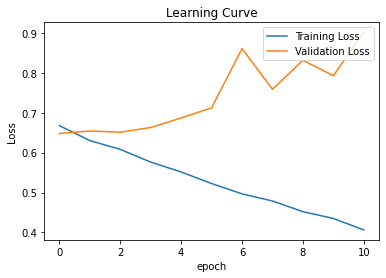

In [40]:
#plotting learning curve
plt.plot(history.history['loss'],label='Training Loss')
plt.plot(history.history['val_loss'],label='Validation Loss')
plt.title('Learning Curve')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(loc='upper right')
plt.show()

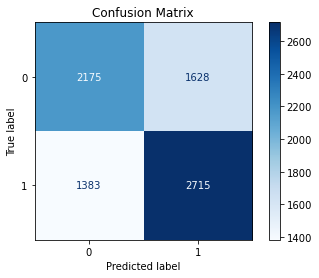

In [43]:
#generating confusion matrix
predictions = model.predict(X_test)
new=predictions.round()
new=np.squeeze(new)
matrix = confusion_matrix(y_test, new)

disp = ConfusionMatrixDisplay(confusion_matrix=matrix)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [44]:
#generating classification report
print(classification_report(y_test,new))

              precision    recall  f1-score   support

           0       0.61      0.57      0.59      3803
           1       0.63      0.66      0.64      4098

    accuracy                           0.62      7901
   macro avg       0.62      0.62      0.62      7901
weighted avg       0.62      0.62      0.62      7901



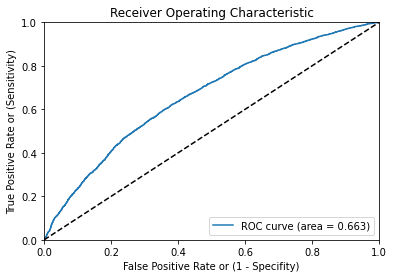

In [45]:
# Generating and plotting ROC curve
pred=np.squeeze(predictions)
precision,recall,thresholds=precision_recall_curve(y_test,predictions)
fpr, tpr, thresholds = roc_curve(y_test, pred)
roc_auc=roc_auc_score(y_test, pred)

plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate or (1 - Specifity)')
plt.ylabel('True Positive Rate or (Sensitivity)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()